In [50]:
# module Import
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch

In [51]:

print (f"PyTorch version:{torch.__version__}") # 1.12.1 이상
print(f"MPS 장치를 지원하도록 build 되었는지: {torch.backends.mps.is_built()}") # True 여야 합니다.
print(f"MPS 장치가 사용 가능한지: {torch.backends.mps.is_available()}") # True 여야 합니다.
#python -c 'import platform;print(platform.platform())'

PyTorch version:2.0.0
MPS 장치를 지원하도록 build 되었는지: True
MPS 장치가 사용 가능한지: True


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from pathlib import Path
import os
from sklearn import preprocessing
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision import models
import cv2

In [15]:
DEVICE = torch.device("mps")
DEVICE

device(type='mps')

In [16]:
x = torch.ones(5, device=mps_device)

NameError: name 'mps_device' is not defined

In [17]:
BATCH_SIZE = 32
EPOCHS = 10

In [18]:
input_root_dir = "/Users/munseunghyeon/input/food-101/food-101"
input_root_path = Path(input_root_dir)
print(os.listdir(input_root_dir))
image_dir_path = input_root_path/'images'

class_path = input_root_dir+'/meta/classes.txt'
train_img_name_path = input_root_dir+'/meta/train.txt'
test_img_name_path = input_root_dir+'/meta/test.txt'

['.DS_Store', 'images', 'meta', 'license_agreement.txt', 'README.txt']


'/Users/munseunghyeon/input/food-101/food-101/meta/train.txt'

In [100]:
train_data

['apple_pie/1005649',
 'apple_pie/1014775',
 'apple_pie/1026328',
 'apple_pie/1028787',
 'apple_pie/1043283',
 'apple_pie/1050519',
 'apple_pie/1057749',
 'apple_pie/1057810',
 'apple_pie/1072416',
 'apple_pie/1074856',
 'apple_pie/1074942',
 'apple_pie/1076891',
 'apple_pie/1077610',
 'apple_pie/1077964',
 'apple_pie/1088809',
 'apple_pie/1097378',
 'apple_pie/1103795',
 'apple_pie/1109597',
 'apple_pie/1111062',
 'apple_pie/1112300',
 'apple_pie/1112838',
 'apple_pie/1121884',
 'apple_pie/112378',
 'apple_pie/1133267',
 'apple_pie/1142597',
 'apple_pie/1147371',
 'apple_pie/1154371',
 'apple_pie/1158360',
 'apple_pie/1159801',
 'apple_pie/1165004',
 'apple_pie/1166116',
 'apple_pie/1166210',
 'apple_pie/116697',
 'apple_pie/1174241',
 'apple_pie/1174949',
 'apple_pie/1177254',
 'apple_pie/118237',
 'apple_pie/1184568',
 'apple_pie/1185445',
 'apple_pie/1185654',
 'apple_pie/1191665',
 'apple_pie/1196628',
 'apple_pie/1199851',
 'apple_pie/1200079',
 'apple_pie/1214326',
 'apple_pie/1

In [20]:
def file2list(path):
    file1 = open(path,'r')
    lines = file1.readlines()
    final_list = [line.strip() for line in lines]
    return final_list


classes = file2list(class_path)
train_data = file2list(train_img_name_path)
test_data = file2list(test_img_name_path)
le = preprocessing.LabelEncoder()
targets = le.fit_transform(classes)

In [21]:
class FoodData(Dataset):
    def __init__(self,img_path,img_dir,size,transform=None):
        self.img_path = img_path
        self.img_dir = img_dir
        self.transform = transform
        self.size = size
#         self.mode = mode
        
    def __len__(self):
        return len(self.img_path)
    
    def __getitem__(self,index):
        label,img_name = self.img_path[index].split('/')
        path = self.img_dir+'/images/'+label+'/'+img_name+'.jpg'
        img = cv2.imread(path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(self.size,self.size))
        if self.transform:
            img = self.transform(img)
        return {
                'gt': img,
                'label': torch.tensor(le.transform([label])[0])
            }

In [22]:
class Cutout(object):
    """Randomly mask out one or more patches from an image.
    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
    """
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

In [23]:
# 참고용 코드
'''data_transform = {
    'train' : transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5,], [0.5, 0.5, 0.5])
    ]),
    'val' : transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5,], [0.5, 0.5, 0.5])
    ]),
}
image_datasets = {x : datasets.ImageFolder("..//")}
dataloaders = {x : torch.utils.data.DataLoader(image_datasets[x], 
                                               batch_size = BATCH_SIZE,
                                               num_workers = 0,
                                               shuffle = True) for x in ["train", "val"]}'''

'data_transform = {\n    \'train\' : transforms.Compose([\n        transforms.RandomResizedCrop(224),\n        transforms.RandomHorizontalFlip(),\n        transforms.ToTensor(),\n        transforms.Normalize([0.5, 0.5, 0.5,], [0.5, 0.5, 0.5])\n    ]),\n    \'val\' : transforms.Compose([\n        transforms.RandomResizedCrop(224),\n        transforms.RandomHorizontalFlip(),\n        transforms.ToTensor(),\n        transforms.Normalize([0.5, 0.5, 0.5,], [0.5, 0.5, 0.5])\n    ]),\n}\nimage_datasets = {x : datasets.ImageFolder("..//")}\ndataloaders = {x : torch.utils.data.DataLoader(image_datasets[x], \n                                               batch_size = BATCH_SIZE,\n                                               num_workers = 0,\n                                               shuffle = True) for x in ["train", "val"]}'

In [24]:
transforms_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(90),
#     transforms.CenterCrop(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(),
#     ImageNetPolicy(),
    
    transforms.ToTensor(),
    transforms.Normalize( mean = np.array([0.485, 0.456, 0.406]),
    std = np.array([0.229, 0.224, 0.225]))
])
train_transforms = transforms.Compose([transforms.ToPILImage(),
                                        transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
train_dataset = FoodData(train_data,input_root_dir,256,transforms_train)

In [143]:
kor_train_data

['Img_020_0774.jpg',
 'Img_020_0012.jpg',
 'Img_020_0006.jpg',
 'Img_020_0760.jpg',
 'Img_020_0748.jpg',
 'Img_020_0990.jpg',
 'Img_020_0984.jpg',
 'Img_020_0953.jpg',
 'Img_020_0947.jpg',
 'Img_020_0210.jpg',
 'Img_020_0576.jpg',
 'Img_020_0562.jpg',
 'Img_020_0204.jpg',
 'Img_020_0238.jpg',
 'Img_020_0589.jpg',
 'Img_020_0364.jpg',
 'Img_020_0402.jpg',
 'Img_020_0416.jpg',
 'Img_020_0370.jpg',
 'Img_020_0358.jpg',
 'Img_020_0600.jpg',
 'Img_020_0166.jpg',
 'Img_020_0172.jpg',
 'Img_020_0614.jpg',
 'Img_020_0628.jpg',
 'Img_020_0827.jpg',
 'Img_020_0199.jpg',
 'Img_020_0833.jpg',
 'Img_020_0832.jpg',
 'Img_020_0826.jpg',
 'Img_020_0198.jpg',
 'Img_020_0629.jpg',
 'Img_020_0173.jpg',
 'Img_020_0615.jpg',
 'Img_020_0601.jpg',
 'Img_020_0167.jpg',
 'Img_020_0359.jpg',
 'Img_020_0417.jpg',
 'Img_020_0371.jpg',
 'Img_020_0365.jpg',
 'Img_020_0403.jpg',
 'Img_020_0588.jpg',
 'Img_020_0239.jpg',
 'Img_020_0563.jpg',
 'Img_020_0205.jpg',
 'Img_020_0211.jpg',
 'Img_020_0577.jpg',
 'Img_020_094

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

torch.Size([3, 256, 256])


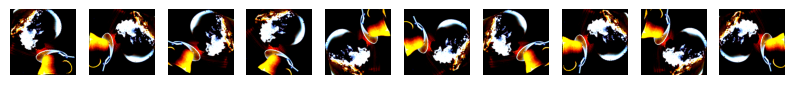

In [26]:
train_dataset.img_path
train_dataset.img_dir , train_dataset.img_path

#image_datasets = {x : datasets.Image}

print(train_dataset.__getitem__(3)['gt'].size())

pltsize = 1
plt.figure(figsize= (10 * pltsize, pltsize))

for i in range(10) :
    plt.subplot(1, 10, i + 1)
    plt.axis("off")
    plt.imshow(np.transpose(train_dataset.__getitem__(3)['gt'], (1,2,0)))

In [27]:
from torch.utils.data.sampler import SubsetRandomSampler

batch = 64
valid_size = 0.2
num = train_data.__len__()
# Dividing the indices for train and cross validation
indices = list(range(num))
np.random.shuffle(indices)
split = int(np.floor(valid_size*num))
train_idx,valid_idx = indices[split:], indices[:split]

#Create Samplers
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(train_dataset, batch_size = batch, sampler = train_sampler)
valid_loader = DataLoader(train_dataset, batch_size = batch, sampler = valid_sampler)

In [39]:
dataloaders = {}
dataset_sizes = {}
dataloaders['train'] = train_loader
dataloaders['val'] = valid_loader
dataset_sizes['train'] = train_sampler.__len__()
dataset_sizes['val'] = valid_sampler.__len__()

In [40]:
''' 6. 불러온 특정 모델에 대하여 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, item in enumerate(train_loader) :
        image = item['gt'].to(DEVICE)
        label = item['label'].to(DEVICE)
        optimizer.zero_grad()
        image = image.to(torch.float32)
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [74]:
''' 7. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
         for batch_idx, item in enumerate(train_loader) :
            image = item['gt'].to(DEVICE)
            label = item['label'].to(DEVICE)
            image = image.to(torch.float32)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    
    return test_loss, test_accuracy

In [31]:
''' 8. PyTorch 내에서 제공하는 미리 학습되지 않은 ResNet18 모델 불러온 후 Output 크기 설정하기 '''
import torchvision.models as models
model = models.resnet18(pretrained = False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 101)
model

/opt/homebrew/anaconda3/envs/cap/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/envs/cap/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [32]:
''' 9. Optimizer, Objective Function 설정하기 '''
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
criterion = nn.CrossEntropyLoss()

print(model) 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [33]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

In [34]:
dataloaders["train"]

NameError: name 'dataloaders' is not defined

In [35]:
    EPOCHS = 1
for epoch in range(1, EPOCHS + 1):
    train(model.to(DEVICE), dataloaders["train"], optimizer, log_interval = 5)
    test_loss, test_accuracy = evaluate(model.to(DEVICE), dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))


IndentationError: expected an indented block after 'for' statement on line 2 (470168896.py, line 3)

In [37]:
model = models.resnet18(pretrained = True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 101)
model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
EPOCHS = 30
for epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, log_interval = 5)
    valid_loss, valid_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, valid_loss, valid_accuracy))

NameError: name 'dataloaders' is not defined

In [41]:
EPOCHS = 20
for epoch in range(1, EPOCHS + 1):
    train(model, dataloaders["train"], optimizer, log_interval = 5)
    valid_loss, valid_accuracy = evaluate(model, dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, valid_loss, valid_accuracy))

Train Epoch: 1 [0/75750 (0%)]	Train Loss: 4.826594
Train Epoch: 1 [320/75750 (1%)]	Train Loss: 4.617962
Train Epoch: 1 [640/75750 (1%)]	Train Loss: 4.457331
Train Epoch: 1 [960/75750 (2%)]	Train Loss: 4.179923
Train Epoch: 1 [1280/75750 (2%)]	Train Loss: 4.487531
Train Epoch: 1 [1600/75750 (3%)]	Train Loss: 3.927227
Train Epoch: 1 [1920/75750 (3%)]	Train Loss: 4.277585
Train Epoch: 1 [2240/75750 (4%)]	Train Loss: 3.947874
Train Epoch: 1 [2560/75750 (4%)]	Train Loss: 4.079782
Train Epoch: 1 [2880/75750 (5%)]	Train Loss: 3.573799
Train Epoch: 1 [3200/75750 (5%)]	Train Loss: 3.888764
Train Epoch: 1 [3520/75750 (6%)]	Train Loss: 3.655310
Train Epoch: 1 [3840/75750 (6%)]	Train Loss: 3.820575
Train Epoch: 1 [4160/75750 (7%)]	Train Loss: 3.827345
Train Epoch: 1 [4480/75750 (7%)]	Train Loss: 3.699093
Train Epoch: 1 [4800/75750 (8%)]	Train Loss: 3.723771
Train Epoch: 1 [5120/75750 (8%)]	Train Loss: 3.649198
Train Epoch: 1 [5440/75750 (9%)]	Train Loss: 3.500782
Train Epoch: 1 [5760/75750 (10%)]	

Train Epoch: 1 [47360/75750 (78%)]	Train Loss: 2.279263
Train Epoch: 1 [47680/75750 (79%)]	Train Loss: 2.227805
Train Epoch: 1 [48000/75750 (79%)]	Train Loss: 2.260692
Train Epoch: 1 [48320/75750 (80%)]	Train Loss: 2.145211
Train Epoch: 1 [48640/75750 (80%)]	Train Loss: 2.350398
Train Epoch: 1 [48960/75750 (81%)]	Train Loss: 2.509999
Train Epoch: 1 [49280/75750 (81%)]	Train Loss: 2.408856
Train Epoch: 1 [49600/75750 (82%)]	Train Loss: 2.340545
Train Epoch: 1 [49920/75750 (82%)]	Train Loss: 2.523020
Train Epoch: 1 [50240/75750 (83%)]	Train Loss: 2.233904
Train Epoch: 1 [50560/75750 (83%)]	Train Loss: 2.389831
Train Epoch: 1 [50880/75750 (84%)]	Train Loss: 2.321275
Train Epoch: 1 [51200/75750 (84%)]	Train Loss: 2.067477
Train Epoch: 1 [51520/75750 (85%)]	Train Loss: 2.632035
Train Epoch: 1 [51840/75750 (86%)]	Train Loss: 2.653159
Train Epoch: 1 [52160/75750 (86%)]	Train Loss: 2.212014
Train Epoch: 1 [52480/75750 (87%)]	Train Loss: 2.341551
Train Epoch: 1 [52800/75750 (87%)]	Train Loss: 2

Train Epoch: 2 [33600/75750 (55%)]	Train Loss: 1.732373
Train Epoch: 2 [33920/75750 (56%)]	Train Loss: 1.826407
Train Epoch: 2 [34240/75750 (56%)]	Train Loss: 2.319041
Train Epoch: 2 [34560/75750 (57%)]	Train Loss: 2.373073
Train Epoch: 2 [34880/75750 (58%)]	Train Loss: 1.684116
Train Epoch: 2 [35200/75750 (58%)]	Train Loss: 1.932918
Train Epoch: 2 [35520/75750 (59%)]	Train Loss: 1.643348
Train Epoch: 2 [35840/75750 (59%)]	Train Loss: 1.973621
Train Epoch: 2 [36160/75750 (60%)]	Train Loss: 2.086313
Train Epoch: 2 [36480/75750 (60%)]	Train Loss: 1.914610
Train Epoch: 2 [36800/75750 (61%)]	Train Loss: 2.036449
Train Epoch: 2 [37120/75750 (61%)]	Train Loss: 1.781115
Train Epoch: 2 [37440/75750 (62%)]	Train Loss: 2.102731
Train Epoch: 2 [37760/75750 (62%)]	Train Loss: 2.292058
Train Epoch: 2 [38080/75750 (63%)]	Train Loss: 2.248838
Train Epoch: 2 [38400/75750 (63%)]	Train Loss: 2.284896
Train Epoch: 2 [38720/75750 (64%)]	Train Loss: 1.809658
Train Epoch: 2 [39040/75750 (64%)]	Train Loss: 2

Train Epoch: 3 [19840/75750 (33%)]	Train Loss: 1.762158
Train Epoch: 3 [20160/75750 (33%)]	Train Loss: 1.669842
Train Epoch: 3 [20480/75750 (34%)]	Train Loss: 1.766939
Train Epoch: 3 [20800/75750 (34%)]	Train Loss: 2.048336
Train Epoch: 3 [21120/75750 (35%)]	Train Loss: 1.559013
Train Epoch: 3 [21440/75750 (35%)]	Train Loss: 1.410000
Train Epoch: 3 [21760/75750 (36%)]	Train Loss: 1.960907
Train Epoch: 3 [22080/75750 (36%)]	Train Loss: 1.803806
Train Epoch: 3 [22400/75750 (37%)]	Train Loss: 1.828249
Train Epoch: 3 [22720/75750 (37%)]	Train Loss: 1.815055
Train Epoch: 3 [23040/75750 (38%)]	Train Loss: 1.556192
Train Epoch: 3 [23360/75750 (39%)]	Train Loss: 1.775580
Train Epoch: 3 [23680/75750 (39%)]	Train Loss: 1.409483
Train Epoch: 3 [24000/75750 (40%)]	Train Loss: 1.640868
Train Epoch: 3 [24320/75750 (40%)]	Train Loss: 1.731039
Train Epoch: 3 [24640/75750 (41%)]	Train Loss: 1.848732
Train Epoch: 3 [24960/75750 (41%)]	Train Loss: 1.679904
Train Epoch: 3 [25280/75750 (42%)]	Train Loss: 1

Train Epoch: 4 [5760/75750 (10%)]	Train Loss: 1.597026
Train Epoch: 4 [6080/75750 (10%)]	Train Loss: 1.633992
Train Epoch: 4 [6400/75750 (11%)]	Train Loss: 1.420391
Train Epoch: 4 [6720/75750 (11%)]	Train Loss: 1.537864
Train Epoch: 4 [7040/75750 (12%)]	Train Loss: 1.284762
Train Epoch: 4 [7360/75750 (12%)]	Train Loss: 1.430120
Train Epoch: 4 [7680/75750 (13%)]	Train Loss: 1.399126
Train Epoch: 4 [8000/75750 (13%)]	Train Loss: 2.116316
Train Epoch: 4 [8320/75750 (14%)]	Train Loss: 1.649486
Train Epoch: 4 [8640/75750 (14%)]	Train Loss: 1.706767
Train Epoch: 4 [8960/75750 (15%)]	Train Loss: 1.505720
Train Epoch: 4 [9280/75750 (15%)]	Train Loss: 1.429885
Train Epoch: 4 [9600/75750 (16%)]	Train Loss: 1.511502
Train Epoch: 4 [9920/75750 (16%)]	Train Loss: 1.539268
Train Epoch: 4 [10240/75750 (17%)]	Train Loss: 1.550983
Train Epoch: 4 [10560/75750 (17%)]	Train Loss: 1.690538
Train Epoch: 4 [10880/75750 (18%)]	Train Loss: 1.651629
Train Epoch: 4 [11200/75750 (18%)]	Train Loss: 1.636785
Train 

Train Epoch: 4 [52800/75750 (87%)]	Train Loss: 1.463577
Train Epoch: 4 [53120/75750 (88%)]	Train Loss: 1.977104
Train Epoch: 4 [53440/75750 (88%)]	Train Loss: 2.052598
Train Epoch: 4 [53760/75750 (89%)]	Train Loss: 1.636942
Train Epoch: 4 [54080/75750 (89%)]	Train Loss: 1.373030
Train Epoch: 4 [54400/75750 (90%)]	Train Loss: 1.691872
Train Epoch: 4 [54720/75750 (90%)]	Train Loss: 1.659047
Train Epoch: 4 [55040/75750 (91%)]	Train Loss: 1.545114
Train Epoch: 4 [55360/75750 (91%)]	Train Loss: 1.478342
Train Epoch: 4 [55680/75750 (92%)]	Train Loss: 1.566396
Train Epoch: 4 [56000/75750 (92%)]	Train Loss: 1.720609
Train Epoch: 4 [56320/75750 (93%)]	Train Loss: 1.676268
Train Epoch: 4 [56640/75750 (93%)]	Train Loss: 1.496093
Train Epoch: 4 [56960/75750 (94%)]	Train Loss: 1.347609
Train Epoch: 4 [57280/75750 (95%)]	Train Loss: 1.587018
Train Epoch: 4 [57600/75750 (95%)]	Train Loss: 1.720910
Train Epoch: 4 [57920/75750 (96%)]	Train Loss: 1.624772
Train Epoch: 4 [58240/75750 (96%)]	Train Loss: 1

Train Epoch: 5 [39040/75750 (64%)]	Train Loss: 1.536229
Train Epoch: 5 [39360/75750 (65%)]	Train Loss: 1.558759
Train Epoch: 5 [39680/75750 (65%)]	Train Loss: 1.228652
Train Epoch: 5 [40000/75750 (66%)]	Train Loss: 1.380662
Train Epoch: 5 [40320/75750 (67%)]	Train Loss: 1.218666
Train Epoch: 5 [40640/75750 (67%)]	Train Loss: 1.322607
Train Epoch: 5 [40960/75750 (68%)]	Train Loss: 1.379950
Train Epoch: 5 [41280/75750 (68%)]	Train Loss: 1.334604
Train Epoch: 5 [41600/75750 (69%)]	Train Loss: 1.606200
Train Epoch: 5 [41920/75750 (69%)]	Train Loss: 1.425390
Train Epoch: 5 [42240/75750 (70%)]	Train Loss: 1.434623
Train Epoch: 5 [42560/75750 (70%)]	Train Loss: 1.422925
Train Epoch: 5 [42880/75750 (71%)]	Train Loss: 1.167332
Train Epoch: 5 [43200/75750 (71%)]	Train Loss: 1.026891
Train Epoch: 5 [43520/75750 (72%)]	Train Loss: 1.895104
Train Epoch: 5 [43840/75750 (72%)]	Train Loss: 1.721854
Train Epoch: 5 [44160/75750 (73%)]	Train Loss: 1.241656
Train Epoch: 5 [44480/75750 (73%)]	Train Loss: 1

Train Epoch: 6 [25280/75750 (42%)]	Train Loss: 1.627579
Train Epoch: 6 [25600/75750 (42%)]	Train Loss: 1.548295
Train Epoch: 6 [25920/75750 (43%)]	Train Loss: 1.387530
Train Epoch: 6 [26240/75750 (43%)]	Train Loss: 1.250389
Train Epoch: 6 [26560/75750 (44%)]	Train Loss: 1.049291
Train Epoch: 6 [26880/75750 (44%)]	Train Loss: 1.099942
Train Epoch: 6 [27200/75750 (45%)]	Train Loss: 1.326807
Train Epoch: 6 [27520/75750 (45%)]	Train Loss: 0.797387
Train Epoch: 6 [27840/75750 (46%)]	Train Loss: 1.474779
Train Epoch: 6 [28160/75750 (46%)]	Train Loss: 1.562515
Train Epoch: 6 [28480/75750 (47%)]	Train Loss: 1.334715
Train Epoch: 6 [28800/75750 (48%)]	Train Loss: 1.297711
Train Epoch: 6 [29120/75750 (48%)]	Train Loss: 1.588760
Train Epoch: 6 [29440/75750 (49%)]	Train Loss: 1.512860
Train Epoch: 6 [29760/75750 (49%)]	Train Loss: 1.040796
Train Epoch: 6 [30080/75750 (50%)]	Train Loss: 1.413856
Train Epoch: 6 [30400/75750 (50%)]	Train Loss: 1.417564
Train Epoch: 6 [30720/75750 (51%)]	Train Loss: 1

Train Epoch: 7 [11520/75750 (19%)]	Train Loss: 1.026480
Train Epoch: 7 [11840/75750 (20%)]	Train Loss: 1.199443
Train Epoch: 7 [12160/75750 (20%)]	Train Loss: 1.664142
Train Epoch: 7 [12480/75750 (21%)]	Train Loss: 1.106197
Train Epoch: 7 [12800/75750 (21%)]	Train Loss: 1.507710
Train Epoch: 7 [13120/75750 (22%)]	Train Loss: 1.743060
Train Epoch: 7 [13440/75750 (22%)]	Train Loss: 1.290572
Train Epoch: 7 [13760/75750 (23%)]	Train Loss: 1.349280
Train Epoch: 7 [14080/75750 (23%)]	Train Loss: 1.421599
Train Epoch: 7 [14400/75750 (24%)]	Train Loss: 1.376046
Train Epoch: 7 [14720/75750 (24%)]	Train Loss: 1.189097
Train Epoch: 7 [15040/75750 (25%)]	Train Loss: 0.989994
Train Epoch: 7 [15360/75750 (25%)]	Train Loss: 1.055345
Train Epoch: 7 [15680/75750 (26%)]	Train Loss: 1.269589
Train Epoch: 7 [16000/75750 (26%)]	Train Loss: 1.315120
Train Epoch: 7 [16320/75750 (27%)]	Train Loss: 0.911491
Train Epoch: 7 [16640/75750 (27%)]	Train Loss: 1.613633
Train Epoch: 7 [16960/75750 (28%)]	Train Loss: 1

Train Epoch: 7 [58560/75750 (97%)]	Train Loss: 1.341159
Train Epoch: 7 [58880/75750 (97%)]	Train Loss: 0.980945
Train Epoch: 7 [59200/75750 (98%)]	Train Loss: 1.474432
Train Epoch: 7 [59520/75750 (98%)]	Train Loss: 1.435533
Train Epoch: 7 [59840/75750 (99%)]	Train Loss: 1.293830
Train Epoch: 7 [60160/75750 (99%)]	Train Loss: 1.446988
Train Epoch: 7 [60480/75750 (100%)]	Train Loss: 1.084234

[EPOCH: 7], 	Test Loss: 0.4896, 	Test Accuracy: 53.26 % 

Train Epoch: 8 [0/75750 (0%)]	Train Loss: 1.487105
Train Epoch: 8 [320/75750 (1%)]	Train Loss: 1.231155
Train Epoch: 8 [640/75750 (1%)]	Train Loss: 0.915757
Train Epoch: 8 [960/75750 (2%)]	Train Loss: 0.980605
Train Epoch: 8 [1280/75750 (2%)]	Train Loss: 0.992572
Train Epoch: 8 [1600/75750 (3%)]	Train Loss: 1.148885
Train Epoch: 8 [1920/75750 (3%)]	Train Loss: 0.887550
Train Epoch: 8 [2240/75750 (4%)]	Train Loss: 1.041828
Train Epoch: 8 [2560/75750 (4%)]	Train Loss: 1.132090
Train Epoch: 8 [2880/75750 (5%)]	Train Loss: 1.252452
Train Epoch: 8

Train Epoch: 8 [44800/75750 (74%)]	Train Loss: 1.570649
Train Epoch: 8 [45120/75750 (74%)]	Train Loss: 0.882031
Train Epoch: 8 [45440/75750 (75%)]	Train Loss: 1.223098
Train Epoch: 8 [45760/75750 (76%)]	Train Loss: 1.069824
Train Epoch: 8 [46080/75750 (76%)]	Train Loss: 0.967947
Train Epoch: 8 [46400/75750 (77%)]	Train Loss: 1.335734
Train Epoch: 8 [46720/75750 (77%)]	Train Loss: 1.195885
Train Epoch: 8 [47040/75750 (78%)]	Train Loss: 1.366283
Train Epoch: 8 [47360/75750 (78%)]	Train Loss: 1.329505
Train Epoch: 8 [47680/75750 (79%)]	Train Loss: 0.915962
Train Epoch: 8 [48000/75750 (79%)]	Train Loss: 1.361642
Train Epoch: 8 [48320/75750 (80%)]	Train Loss: 1.147432
Train Epoch: 8 [48640/75750 (80%)]	Train Loss: 1.215818
Train Epoch: 8 [48960/75750 (81%)]	Train Loss: 1.049029
Train Epoch: 8 [49280/75750 (81%)]	Train Loss: 1.202106
Train Epoch: 8 [49600/75750 (82%)]	Train Loss: 1.296682
Train Epoch: 8 [49920/75750 (82%)]	Train Loss: 1.273966
Train Epoch: 8 [50240/75750 (83%)]	Train Loss: 0

Train Epoch: 9 [31040/75750 (51%)]	Train Loss: 0.931949
Train Epoch: 9 [31360/75750 (52%)]	Train Loss: 1.358754
Train Epoch: 9 [31680/75750 (52%)]	Train Loss: 1.056409
Train Epoch: 9 [32000/75750 (53%)]	Train Loss: 1.404830
Train Epoch: 9 [32320/75750 (53%)]	Train Loss: 1.641396
Train Epoch: 9 [32640/75750 (54%)]	Train Loss: 1.003211
Train Epoch: 9 [32960/75750 (54%)]	Train Loss: 1.038595
Train Epoch: 9 [33280/75750 (55%)]	Train Loss: 0.929285
Train Epoch: 9 [33600/75750 (55%)]	Train Loss: 1.371258
Train Epoch: 9 [33920/75750 (56%)]	Train Loss: 1.198737
Train Epoch: 9 [34240/75750 (56%)]	Train Loss: 1.176949
Train Epoch: 9 [34560/75750 (57%)]	Train Loss: 1.079529
Train Epoch: 9 [34880/75750 (58%)]	Train Loss: 1.074912
Train Epoch: 9 [35200/75750 (58%)]	Train Loss: 1.272642
Train Epoch: 9 [35520/75750 (59%)]	Train Loss: 0.987732
Train Epoch: 9 [35840/75750 (59%)]	Train Loss: 1.188466
Train Epoch: 9 [36160/75750 (60%)]	Train Loss: 1.303379
Train Epoch: 9 [36480/75750 (60%)]	Train Loss: 1

Train Epoch: 10 [16960/75750 (28%)]	Train Loss: 1.328270
Train Epoch: 10 [17280/75750 (29%)]	Train Loss: 0.988830
Train Epoch: 10 [17600/75750 (29%)]	Train Loss: 0.892163
Train Epoch: 10 [17920/75750 (30%)]	Train Loss: 0.626288
Train Epoch: 10 [18240/75750 (30%)]	Train Loss: 1.186866
Train Epoch: 10 [18560/75750 (31%)]	Train Loss: 0.677231
Train Epoch: 10 [18880/75750 (31%)]	Train Loss: 1.208855
Train Epoch: 10 [19200/75750 (32%)]	Train Loss: 0.930992
Train Epoch: 10 [19520/75750 (32%)]	Train Loss: 0.939940
Train Epoch: 10 [19840/75750 (33%)]	Train Loss: 1.496011
Train Epoch: 10 [20160/75750 (33%)]	Train Loss: 0.815893
Train Epoch: 10 [20480/75750 (34%)]	Train Loss: 1.146233
Train Epoch: 10 [20800/75750 (34%)]	Train Loss: 1.169820
Train Epoch: 10 [21120/75750 (35%)]	Train Loss: 1.150887
Train Epoch: 10 [21440/75750 (35%)]	Train Loss: 0.837504
Train Epoch: 10 [21760/75750 (36%)]	Train Loss: 1.121513
Train Epoch: 10 [22080/75750 (36%)]	Train Loss: 1.090186
Train Epoch: 10 [22400/75750 (3

Train Epoch: 11 [1920/75750 (3%)]	Train Loss: 0.963551
Train Epoch: 11 [2240/75750 (4%)]	Train Loss: 1.132824
Train Epoch: 11 [2560/75750 (4%)]	Train Loss: 0.864944
Train Epoch: 11 [2880/75750 (5%)]	Train Loss: 0.756509
Train Epoch: 11 [3200/75750 (5%)]	Train Loss: 0.960037
Train Epoch: 11 [3520/75750 (6%)]	Train Loss: 0.955432
Train Epoch: 11 [3840/75750 (6%)]	Train Loss: 1.154469
Train Epoch: 11 [4160/75750 (7%)]	Train Loss: 0.950847
Train Epoch: 11 [4480/75750 (7%)]	Train Loss: 0.927832
Train Epoch: 11 [4800/75750 (8%)]	Train Loss: 1.089276
Train Epoch: 11 [5120/75750 (8%)]	Train Loss: 1.033013
Train Epoch: 11 [5440/75750 (9%)]	Train Loss: 0.814942
Train Epoch: 11 [5760/75750 (10%)]	Train Loss: 0.761625
Train Epoch: 11 [6080/75750 (10%)]	Train Loss: 1.116982
Train Epoch: 11 [6400/75750 (11%)]	Train Loss: 1.082067
Train Epoch: 11 [6720/75750 (11%)]	Train Loss: 0.749036
Train Epoch: 11 [7040/75750 (12%)]	Train Loss: 0.750647
Train Epoch: 11 [7360/75750 (12%)]	Train Loss: 0.635766
Trai

Train Epoch: 11 [48320/75750 (80%)]	Train Loss: 1.162181
Train Epoch: 11 [48640/75750 (80%)]	Train Loss: 1.146132
Train Epoch: 11 [48960/75750 (81%)]	Train Loss: 0.924277
Train Epoch: 11 [49280/75750 (81%)]	Train Loss: 1.509383
Train Epoch: 11 [49600/75750 (82%)]	Train Loss: 1.078057
Train Epoch: 11 [49920/75750 (82%)]	Train Loss: 1.104952
Train Epoch: 11 [50240/75750 (83%)]	Train Loss: 0.885158
Train Epoch: 11 [50560/75750 (83%)]	Train Loss: 0.798519
Train Epoch: 11 [50880/75750 (84%)]	Train Loss: 1.637652
Train Epoch: 11 [51200/75750 (84%)]	Train Loss: 1.222754
Train Epoch: 11 [51520/75750 (85%)]	Train Loss: 1.166703
Train Epoch: 11 [51840/75750 (86%)]	Train Loss: 1.073447
Train Epoch: 11 [52160/75750 (86%)]	Train Loss: 0.769950
Train Epoch: 11 [52480/75750 (87%)]	Train Loss: 1.034052
Train Epoch: 11 [52800/75750 (87%)]	Train Loss: 1.427087
Train Epoch: 11 [53120/75750 (88%)]	Train Loss: 1.006318
Train Epoch: 11 [53440/75750 (88%)]	Train Loss: 1.264455
Train Epoch: 11 [53760/75750 (8

Train Epoch: 12 [33600/75750 (55%)]	Train Loss: 0.922843
Train Epoch: 12 [33920/75750 (56%)]	Train Loss: 0.635485
Train Epoch: 12 [34240/75750 (56%)]	Train Loss: 0.875888
Train Epoch: 12 [34560/75750 (57%)]	Train Loss: 1.378582
Train Epoch: 12 [34880/75750 (58%)]	Train Loss: 0.866558
Train Epoch: 12 [35200/75750 (58%)]	Train Loss: 1.040883
Train Epoch: 12 [35520/75750 (59%)]	Train Loss: 0.779150
Train Epoch: 12 [35840/75750 (59%)]	Train Loss: 0.593385
Train Epoch: 12 [36160/75750 (60%)]	Train Loss: 1.075934
Train Epoch: 12 [36480/75750 (60%)]	Train Loss: 1.322579
Train Epoch: 12 [36800/75750 (61%)]	Train Loss: 0.966639
Train Epoch: 12 [37120/75750 (61%)]	Train Loss: 1.406983
Train Epoch: 12 [37440/75750 (62%)]	Train Loss: 1.139616
Train Epoch: 12 [37760/75750 (62%)]	Train Loss: 0.904223
Train Epoch: 12 [38080/75750 (63%)]	Train Loss: 1.134802
Train Epoch: 12 [38400/75750 (63%)]	Train Loss: 0.948359
Train Epoch: 12 [38720/75750 (64%)]	Train Loss: 0.930167
Train Epoch: 12 [39040/75750 (6

Train Epoch: 13 [18880/75750 (31%)]	Train Loss: 1.140957
Train Epoch: 13 [19200/75750 (32%)]	Train Loss: 0.902851
Train Epoch: 13 [19520/75750 (32%)]	Train Loss: 1.042819
Train Epoch: 13 [19840/75750 (33%)]	Train Loss: 1.112730
Train Epoch: 13 [20160/75750 (33%)]	Train Loss: 1.037317
Train Epoch: 13 [20480/75750 (34%)]	Train Loss: 1.038329
Train Epoch: 13 [20800/75750 (34%)]	Train Loss: 1.023034
Train Epoch: 13 [21120/75750 (35%)]	Train Loss: 0.651729
Train Epoch: 13 [21440/75750 (35%)]	Train Loss: 1.165222
Train Epoch: 13 [21760/75750 (36%)]	Train Loss: 1.129970
Train Epoch: 13 [22080/75750 (36%)]	Train Loss: 0.805686
Train Epoch: 13 [22400/75750 (37%)]	Train Loss: 0.900450
Train Epoch: 13 [22720/75750 (37%)]	Train Loss: 0.692879
Train Epoch: 13 [23040/75750 (38%)]	Train Loss: 0.833474
Train Epoch: 13 [23360/75750 (39%)]	Train Loss: 1.097792
Train Epoch: 13 [23680/75750 (39%)]	Train Loss: 0.926781
Train Epoch: 13 [24000/75750 (40%)]	Train Loss: 1.012461
Train Epoch: 13 [24320/75750 (4

Train Epoch: 14 [4160/75750 (7%)]	Train Loss: 0.717121
Train Epoch: 14 [4480/75750 (7%)]	Train Loss: 0.875898
Train Epoch: 14 [4800/75750 (8%)]	Train Loss: 0.771064
Train Epoch: 14 [5120/75750 (8%)]	Train Loss: 0.759658
Train Epoch: 14 [5440/75750 (9%)]	Train Loss: 1.008853
Train Epoch: 14 [5760/75750 (10%)]	Train Loss: 0.894525
Train Epoch: 14 [6080/75750 (10%)]	Train Loss: 0.996059
Train Epoch: 14 [6400/75750 (11%)]	Train Loss: 0.676102
Train Epoch: 14 [6720/75750 (11%)]	Train Loss: 0.698307
Train Epoch: 14 [7040/75750 (12%)]	Train Loss: 0.965171
Train Epoch: 14 [7360/75750 (12%)]	Train Loss: 0.685661
Train Epoch: 14 [7680/75750 (13%)]	Train Loss: 0.592710
Train Epoch: 14 [8000/75750 (13%)]	Train Loss: 0.872624
Train Epoch: 14 [8320/75750 (14%)]	Train Loss: 0.697675
Train Epoch: 14 [8640/75750 (14%)]	Train Loss: 0.944595
Train Epoch: 14 [8960/75750 (15%)]	Train Loss: 0.707439
Train Epoch: 14 [9280/75750 (15%)]	Train Loss: 0.606262
Train Epoch: 14 [9600/75750 (16%)]	Train Loss: 0.9840

Train Epoch: 14 [50560/75750 (83%)]	Train Loss: 0.833166
Train Epoch: 14 [50880/75750 (84%)]	Train Loss: 0.747296
Train Epoch: 14 [51200/75750 (84%)]	Train Loss: 0.852888
Train Epoch: 14 [51520/75750 (85%)]	Train Loss: 1.151057
Train Epoch: 14 [51840/75750 (86%)]	Train Loss: 0.992732
Train Epoch: 14 [52160/75750 (86%)]	Train Loss: 0.639962
Train Epoch: 14 [52480/75750 (87%)]	Train Loss: 0.536770
Train Epoch: 14 [52800/75750 (87%)]	Train Loss: 1.364442
Train Epoch: 14 [53120/75750 (88%)]	Train Loss: 0.702759
Train Epoch: 14 [53440/75750 (88%)]	Train Loss: 0.647595
Train Epoch: 14 [53760/75750 (89%)]	Train Loss: 0.972533
Train Epoch: 14 [54080/75750 (89%)]	Train Loss: 0.765920
Train Epoch: 14 [54400/75750 (90%)]	Train Loss: 0.993301
Train Epoch: 14 [54720/75750 (90%)]	Train Loss: 0.794173
Train Epoch: 14 [55040/75750 (91%)]	Train Loss: 1.127444
Train Epoch: 14 [55360/75750 (91%)]	Train Loss: 1.090046
Train Epoch: 14 [55680/75750 (92%)]	Train Loss: 0.854703
Train Epoch: 14 [56000/75750 (9

Train Epoch: 15 [35840/75750 (59%)]	Train Loss: 1.128998
Train Epoch: 15 [36160/75750 (60%)]	Train Loss: 1.014287
Train Epoch: 15 [36480/75750 (60%)]	Train Loss: 0.827538
Train Epoch: 15 [36800/75750 (61%)]	Train Loss: 0.742767
Train Epoch: 15 [37120/75750 (61%)]	Train Loss: 0.692186
Train Epoch: 15 [37440/75750 (62%)]	Train Loss: 1.062421
Train Epoch: 15 [37760/75750 (62%)]	Train Loss: 0.993663
Train Epoch: 15 [38080/75750 (63%)]	Train Loss: 0.596522
Train Epoch: 15 [38400/75750 (63%)]	Train Loss: 0.762940
Train Epoch: 15 [38720/75750 (64%)]	Train Loss: 0.629964
Train Epoch: 15 [39040/75750 (64%)]	Train Loss: 0.936071
Train Epoch: 15 [39360/75750 (65%)]	Train Loss: 0.840039
Train Epoch: 15 [39680/75750 (65%)]	Train Loss: 1.071028
Train Epoch: 15 [40000/75750 (66%)]	Train Loss: 0.777771
Train Epoch: 15 [40320/75750 (67%)]	Train Loss: 1.030510
Train Epoch: 15 [40640/75750 (67%)]	Train Loss: 0.793886
Train Epoch: 15 [40960/75750 (68%)]	Train Loss: 0.838465
Train Epoch: 15 [41280/75750 (6

Train Epoch: 16 [21120/75750 (35%)]	Train Loss: 1.028582
Train Epoch: 16 [21440/75750 (35%)]	Train Loss: 1.011154
Train Epoch: 16 [21760/75750 (36%)]	Train Loss: 0.427758
Train Epoch: 16 [22080/75750 (36%)]	Train Loss: 0.786237
Train Epoch: 16 [22400/75750 (37%)]	Train Loss: 0.721019
Train Epoch: 16 [22720/75750 (37%)]	Train Loss: 0.612864
Train Epoch: 16 [23040/75750 (38%)]	Train Loss: 0.796108
Train Epoch: 16 [23360/75750 (39%)]	Train Loss: 0.625155
Train Epoch: 16 [23680/75750 (39%)]	Train Loss: 0.795117
Train Epoch: 16 [24000/75750 (40%)]	Train Loss: 0.485303
Train Epoch: 16 [24320/75750 (40%)]	Train Loss: 0.585561
Train Epoch: 16 [24640/75750 (41%)]	Train Loss: 0.564229
Train Epoch: 16 [24960/75750 (41%)]	Train Loss: 0.651082
Train Epoch: 16 [25280/75750 (42%)]	Train Loss: 0.694319
Train Epoch: 16 [25600/75750 (42%)]	Train Loss: 0.754922
Train Epoch: 16 [25920/75750 (43%)]	Train Loss: 0.913797
Train Epoch: 16 [26240/75750 (43%)]	Train Loss: 0.690190
Train Epoch: 16 [26560/75750 (4

Train Epoch: 17 [6400/75750 (11%)]	Train Loss: 0.905559
Train Epoch: 17 [6720/75750 (11%)]	Train Loss: 0.371337
Train Epoch: 17 [7040/75750 (12%)]	Train Loss: 0.524502
Train Epoch: 17 [7360/75750 (12%)]	Train Loss: 0.656247
Train Epoch: 17 [7680/75750 (13%)]	Train Loss: 0.732437
Train Epoch: 17 [8000/75750 (13%)]	Train Loss: 0.641001
Train Epoch: 17 [8320/75750 (14%)]	Train Loss: 0.679119
Train Epoch: 17 [8640/75750 (14%)]	Train Loss: 0.436577
Train Epoch: 17 [8960/75750 (15%)]	Train Loss: 0.650321
Train Epoch: 17 [9280/75750 (15%)]	Train Loss: 0.467087
Train Epoch: 17 [9600/75750 (16%)]	Train Loss: 0.504379
Train Epoch: 17 [9920/75750 (16%)]	Train Loss: 0.453604
Train Epoch: 17 [10240/75750 (17%)]	Train Loss: 0.736529
Train Epoch: 17 [10560/75750 (17%)]	Train Loss: 0.777631
Train Epoch: 17 [10880/75750 (18%)]	Train Loss: 0.610920
Train Epoch: 17 [11200/75750 (18%)]	Train Loss: 1.014093
Train Epoch: 17 [11520/75750 (19%)]	Train Loss: 0.740272
Train Epoch: 17 [11840/75750 (20%)]	Train L

Train Epoch: 17 [52480/75750 (87%)]	Train Loss: 0.644792
Train Epoch: 17 [52800/75750 (87%)]	Train Loss: 1.000380
Train Epoch: 17 [53120/75750 (88%)]	Train Loss: 0.741394
Train Epoch: 17 [53440/75750 (88%)]	Train Loss: 1.069051
Train Epoch: 17 [53760/75750 (89%)]	Train Loss: 0.784186
Train Epoch: 17 [54080/75750 (89%)]	Train Loss: 0.630420
Train Epoch: 17 [54400/75750 (90%)]	Train Loss: 0.697286
Train Epoch: 17 [54720/75750 (90%)]	Train Loss: 0.601781
Train Epoch: 17 [55040/75750 (91%)]	Train Loss: 0.807154
Train Epoch: 17 [55360/75750 (91%)]	Train Loss: 0.819594
Train Epoch: 17 [55680/75750 (92%)]	Train Loss: 0.798564
Train Epoch: 17 [56000/75750 (92%)]	Train Loss: 0.990250
Train Epoch: 17 [56320/75750 (93%)]	Train Loss: 0.698176
Train Epoch: 17 [56640/75750 (93%)]	Train Loss: 0.604161
Train Epoch: 17 [56960/75750 (94%)]	Train Loss: 0.694566
Train Epoch: 17 [57280/75750 (95%)]	Train Loss: 0.499459
Train Epoch: 17 [57600/75750 (95%)]	Train Loss: 0.701811
Train Epoch: 17 [57920/75750 (9

Train Epoch: 18 [37760/75750 (62%)]	Train Loss: 0.598953
Train Epoch: 18 [38080/75750 (63%)]	Train Loss: 0.547675
Train Epoch: 18 [38400/75750 (63%)]	Train Loss: 0.848166
Train Epoch: 18 [38720/75750 (64%)]	Train Loss: 0.689641
Train Epoch: 18 [39040/75750 (64%)]	Train Loss: 1.150056
Train Epoch: 18 [39360/75750 (65%)]	Train Loss: 0.870345
Train Epoch: 18 [39680/75750 (65%)]	Train Loss: 0.715037
Train Epoch: 18 [40000/75750 (66%)]	Train Loss: 0.772041
Train Epoch: 18 [40320/75750 (67%)]	Train Loss: 0.704238
Train Epoch: 18 [40640/75750 (67%)]	Train Loss: 0.656009
Train Epoch: 18 [40960/75750 (68%)]	Train Loss: 0.616173
Train Epoch: 18 [41280/75750 (68%)]	Train Loss: 0.604564
Train Epoch: 18 [41600/75750 (69%)]	Train Loss: 0.644028
Train Epoch: 18 [41920/75750 (69%)]	Train Loss: 0.673369
Train Epoch: 18 [42240/75750 (70%)]	Train Loss: 0.887464
Train Epoch: 18 [42560/75750 (70%)]	Train Loss: 0.730175
Train Epoch: 18 [42880/75750 (71%)]	Train Loss: 0.886469
Train Epoch: 18 [43200/75750 (7

Train Epoch: 19 [23040/75750 (38%)]	Train Loss: 0.731014
Train Epoch: 19 [23360/75750 (39%)]	Train Loss: 0.488417
Train Epoch: 19 [23680/75750 (39%)]	Train Loss: 0.502531
Train Epoch: 19 [24000/75750 (40%)]	Train Loss: 0.729189
Train Epoch: 19 [24320/75750 (40%)]	Train Loss: 0.956330
Train Epoch: 19 [24640/75750 (41%)]	Train Loss: 0.728444
Train Epoch: 19 [24960/75750 (41%)]	Train Loss: 0.737235
Train Epoch: 19 [25280/75750 (42%)]	Train Loss: 0.843961
Train Epoch: 19 [25600/75750 (42%)]	Train Loss: 0.464752
Train Epoch: 19 [25920/75750 (43%)]	Train Loss: 0.693747
Train Epoch: 19 [26240/75750 (43%)]	Train Loss: 0.996216
Train Epoch: 19 [26560/75750 (44%)]	Train Loss: 0.508624
Train Epoch: 19 [26880/75750 (44%)]	Train Loss: 0.701660
Train Epoch: 19 [27200/75750 (45%)]	Train Loss: 0.651978
Train Epoch: 19 [27520/75750 (45%)]	Train Loss: 0.457502
Train Epoch: 19 [27840/75750 (46%)]	Train Loss: 0.576258
Train Epoch: 19 [28160/75750 (46%)]	Train Loss: 0.584375
Train Epoch: 19 [28480/75750 (4

Train Epoch: 20 [8320/75750 (14%)]	Train Loss: 0.511671
Train Epoch: 20 [8640/75750 (14%)]	Train Loss: 0.461486
Train Epoch: 20 [8960/75750 (15%)]	Train Loss: 0.378881
Train Epoch: 20 [9280/75750 (15%)]	Train Loss: 0.636883
Train Epoch: 20 [9600/75750 (16%)]	Train Loss: 0.444756
Train Epoch: 20 [9920/75750 (16%)]	Train Loss: 0.479487
Train Epoch: 20 [10240/75750 (17%)]	Train Loss: 0.547808
Train Epoch: 20 [10560/75750 (17%)]	Train Loss: 0.586512
Train Epoch: 20 [10880/75750 (18%)]	Train Loss: 0.482699
Train Epoch: 20 [11200/75750 (18%)]	Train Loss: 0.396162
Train Epoch: 20 [11520/75750 (19%)]	Train Loss: 0.620592
Train Epoch: 20 [11840/75750 (20%)]	Train Loss: 0.705649
Train Epoch: 20 [12160/75750 (20%)]	Train Loss: 0.690992
Train Epoch: 20 [12480/75750 (21%)]	Train Loss: 0.624830
Train Epoch: 20 [12800/75750 (21%)]	Train Loss: 0.675170
Train Epoch: 20 [13120/75750 (22%)]	Train Loss: 0.706746
Train Epoch: 20 [13440/75750 (22%)]	Train Loss: 0.699423
Train Epoch: 20 [13760/75750 (23%)]	T

Train Epoch: 20 [54400/75750 (90%)]	Train Loss: 0.394702
Train Epoch: 20 [54720/75750 (90%)]	Train Loss: 0.897893
Train Epoch: 20 [55040/75750 (91%)]	Train Loss: 0.698949
Train Epoch: 20 [55360/75750 (91%)]	Train Loss: 0.701531
Train Epoch: 20 [55680/75750 (92%)]	Train Loss: 0.370643
Train Epoch: 20 [56000/75750 (92%)]	Train Loss: 0.642194
Train Epoch: 20 [56320/75750 (93%)]	Train Loss: 0.528811
Train Epoch: 20 [56640/75750 (93%)]	Train Loss: 0.613721
Train Epoch: 20 [56960/75750 (94%)]	Train Loss: 0.647261
Train Epoch: 20 [57280/75750 (95%)]	Train Loss: 0.672799
Train Epoch: 20 [57600/75750 (95%)]	Train Loss: 0.544688
Train Epoch: 20 [57920/75750 (96%)]	Train Loss: 0.959501
Train Epoch: 20 [58240/75750 (96%)]	Train Loss: 0.607163
Train Epoch: 20 [58560/75750 (97%)]	Train Loss: 0.674534
Train Epoch: 20 [58880/75750 (97%)]	Train Loss: 0.618943
Train Epoch: 20 [59200/75750 (98%)]	Train Loss: 0.523559
Train Epoch: 20 [59520/75750 (98%)]	Train Loss: 0.460878
Train Epoch: 20 [59840/75750 (9

In [49]:
PATH = 'weights/'
torch.save(model, PATH + 'model.pt')  # 전체 모델 저장
torch.save(model.state_dict(), PATH + 'model_state_dict.pt')  # 모델 객체의 state_dict 저장
torch.save({
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict()
}, PATH + 'all.tar')  # 여러 가지 값 저장, 학습 중 진행 상황 저장을 위해 epoch, loss 값 등 일반 scalar값 저장 가능

In [32]:
model.load_state_dict(torch.load(PATH + 'model_state_dict.pt')) 

In [66]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, item in enumerate(train_loader):
            image = item['gt'].to(DEVICE)
            label = item['label'].to(DEVICE)
            image = image.to(torch.float32)
            output = model(image)
            test_loss += criterion(output, label).item()
            # 상위 5개의 예측을 반환합니다.
            prediction = output.topk(5, dim=1)[1]
            # 정답이 상위 5개 예측 중 하나라면 correct 변수의 값을 증가시킵니다.
            correct += prediction.eq(label.view(-1, 1).expand_as(prediction)).sum().item()
    
    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    
    return test_loss, test_accuracy


In [68]:
valid_loss, valid_accuracy = evaluate(model, dataloaders["val"])

In [144]:
import glob

## 한식 데이터 학습 추가
kor_input_root_dir = "/Users/munseunghyeon/Documents/kor_food"
kor_input_root_path = Path(kor_input_root_dir)
a = glob.glob("/Users/munseunghyeon/Documents/kor_food/*")
print(os.listdir(kor_input_root_dir))

print(len(os.listdir(kor_input_root_dir)))


kor_train_data = file2list("/Users/munseunghyeon/Documents/kor_food/meta/kor_train_data.txt")

['.DS_Store', 'preprocess.py', 'images', 'meta']
4


In [146]:
kor_train_data

['Img_020_0774.jpg',
 'Img_020_0012.jpg',
 'Img_020_0006.jpg',
 'Img_020_0760.jpg',
 'Img_020_0748.jpg',
 'Img_020_0990.jpg',
 'Img_020_0984.jpg',
 'Img_020_0953.jpg',
 'Img_020_0947.jpg',
 'Img_020_0210.jpg',
 'Img_020_0576.jpg',
 'Img_020_0562.jpg',
 'Img_020_0204.jpg',
 'Img_020_0238.jpg',
 'Img_020_0589.jpg',
 'Img_020_0364.jpg',
 'Img_020_0402.jpg',
 'Img_020_0416.jpg',
 'Img_020_0370.jpg',
 'Img_020_0358.jpg',
 'Img_020_0600.jpg',
 'Img_020_0166.jpg',
 'Img_020_0172.jpg',
 'Img_020_0614.jpg',
 'Img_020_0628.jpg',
 'Img_020_0827.jpg',
 'Img_020_0199.jpg',
 'Img_020_0833.jpg',
 'Img_020_0832.jpg',
 'Img_020_0826.jpg',
 'Img_020_0198.jpg',
 'Img_020_0629.jpg',
 'Img_020_0173.jpg',
 'Img_020_0615.jpg',
 'Img_020_0601.jpg',
 'Img_020_0167.jpg',
 'Img_020_0359.jpg',
 'Img_020_0417.jpg',
 'Img_020_0371.jpg',
 'Img_020_0365.jpg',
 'Img_020_0403.jpg',
 'Img_020_0588.jpg',
 'Img_020_0239.jpg',
 'Img_020_0563.jpg',
 'Img_020_0205.jpg',
 'Img_020_0211.jpg',
 'Img_020_0577.jpg',
 'Img_020_094

In [103]:
kor_train_dataset = FoodData(kor_train_data, kor_input_root_dir, 256, transforms_train)

In [106]:
batch = 64
valid_size = 0.2
num = kor_train_data.__len__()
# Dividing the indices for train and cross validation
indices = list(range(num))
np.random.shuffle(indices)
split = int(np.floor(valid_size*num))
kor_train_idx,kor_valid_idx = indices[split:], indices[:split]

#Create Samplers
kor_train_sampler = SubsetRandomSampler(kor_train_idx)
kor_valid_sampler = SubsetRandomSampler(kor_valid_idx)

kor_train_loader = DataLoader(kor_train_dataset, batch_size = batch, sampler = kor_train_sampler)
kor_valid_loader = DataLoader(kor_train_dataset, batch_size = batch, sampler = kor_valid_sampler)

In [107]:
kor_dataloaders = {}
kor_dataset_sizes = {}
kor_dataloaders['train'] = kor_train_loader
kor_dataloaders['val'] = kor_valid_loader
kor_dataset_sizes['train'] = kor_train_sampler.__len__()
kor_dataset_sizes['val'] = kor_valid_sampler.__len__()

In [99]:
print(train_img_name_path)

/Users/munseunghyeon/input/food-101/food-101/meta/train.txt


In [77]:
   print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        EPOCHS, valid_loss, valid_accuracy))


[EPOCH: 40], 	Test Loss: 0.2233, 	Test Accuracy: 68.37 % 



In [73]:
   print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        EPOCHS, valid_loss, valid_accuracy))


[EPOCH: 40], 	Test Loss: 0.2233, 	Test Accuracy: 83.07 % 



In [127]:
for batch_idx, item in enumerate(kor_dataloaders['train']) :
        image = item['gt'].to(DEVICE)
        label = item['label'].to(DEVICE)
        optimizer.zero_grad()
        image = image.to(torch.float32)
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

ValueError: not enough values to unpack (expected 2, got 1)

In [139]:
for i in kor_dataloaders['train'] :
    print(i)

ValueError: not enough values to unpack (expected 2, got 1)

In [115]:
model2 = models.resnet18()
num_ftrs = model2.fc.in_features
model2.fc = nn.Linear(num_ftrs, 150)
model2 = model2.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)


EPOCHS = 2
for epoch in range(1, EPOCHS + 1):
    train(model2, kor_dataloaders["train"], optimizer, log_interval = 5)
    valid_loss, valid_accuracy = evaluate(model2, kor_dataloaders["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, valid_loss, valid_accuracy))

ValueError: not enough values to unpack (expected 2, got 1)

In [112]:
dataloaders['train'].__len__()

947

In [114]:
kor_dataloaders['train'].__len__()

1848

In [126]:

#train_dataset
